<a href="https://colab.research.google.com/github/jonkolp/Network/blob/main/Pattern(Sentiment_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

tweet_sentiment_extraction_path = kagglehub.competition_download('tweet-sentiment-extraction')
rohitsingh9990_tse_spacy_model_path = kagglehub.dataset_download('rohitsingh9990/tse-spacy-model')

print('Data source import complete.')


100%|██████████| 1.39M/1.39M [00:00<00:00, 1.87MB/s]

Extracting files...


100%|██████████| 15.4M/15.4M [00:01<00:00, 11.9MB/s]

Extracting files...


Data source import complete.


# Imports

In [2]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

# Reading the Data

In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
ss = pd.read_csv('/content/sample_submission.csv')

In [4]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [5]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [6]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [7]:
test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [8]:
train.dropna(inplace=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


# EDA

In [12]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [13]:
train.describe()

textID                                               text  \
count        27480                                              27480   
unique       27480                                              27480   
top     6f7127d9d7     All this flirting going on - The ATG smiles...   
freq             1                                                  1   

       selected_text sentiment  
count          27480     27480  
unique         22463         3  
top             good   neutral  
freq             199     11117

In [14]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

<Axes: xlabel='sentiment', ylabel='count'>

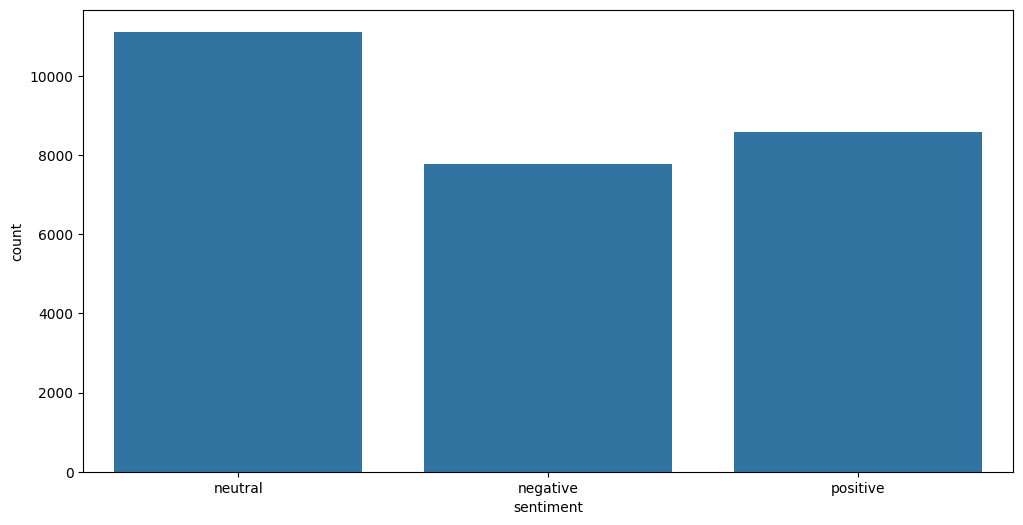

In [15]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [10]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [11]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [17]:
print(results_jaccard)

[[' I`d have responded, if I were going', 'I`d have responded, if I were going', 1.0], [' Sooo SAD I will miss you here in San Diego!!!', 'Sooo SAD', 0.2], ['my boss is bullying me...', 'bullying me', 0.16666666666666666], [' what interview! leave me alone', 'leave me alone', 0.6], [' Sons of ****, why couldn`t they put them on the releases we already bought', 'Sons of ****,', 0.21428571428571427], ['http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth', 'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth', 1.0], ['2am feedings for the baby are fun when he is all smiles and coos', 'fun', 0.07142857142857142], ['Soooo high', 'Soooo high', 1.0], [' Both of you', 'Both of you', 1.0], [' Journey!? Wow... u just became cooler.  hehe... (is that possible!?)', 'Wow... u just became cooler.', 0.5], [' as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff', 'as 

In [12]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [13]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [14]:
train.head()

textID                                               text  \
0  0fab80d6b2                    \tREALLY?? oh.. sorry yall  lol   
1  8106d4c6fa                          _beckett Thanks so much !   
2  3792c7b13e        You`ll be missed!!  Bring me back  a key...   
3  b58a92fe10                 get lit  I am  http://bit.ly/OASQR   
4  18180bb2ec       Good morning to you !  Its so pretty outs...   

                   selected_text sentiment  jaccard_score  Num_words_ST  \
0                          sorry  negative       0.200000             1   
1                 beckett Thanks  positive       0.166667             2   
2                 You`ll be miss  negative       0.222222             3   
3  get lit  I am  http://bit.ly/   neutral       0.666667             5   
4                      Its so pr  positive       0.181818             3   

   Num_word_text  difference_in_words  
0              5                    4  
1              5                    3  
2              8                    5  
3              5                    0  
4             10                    7

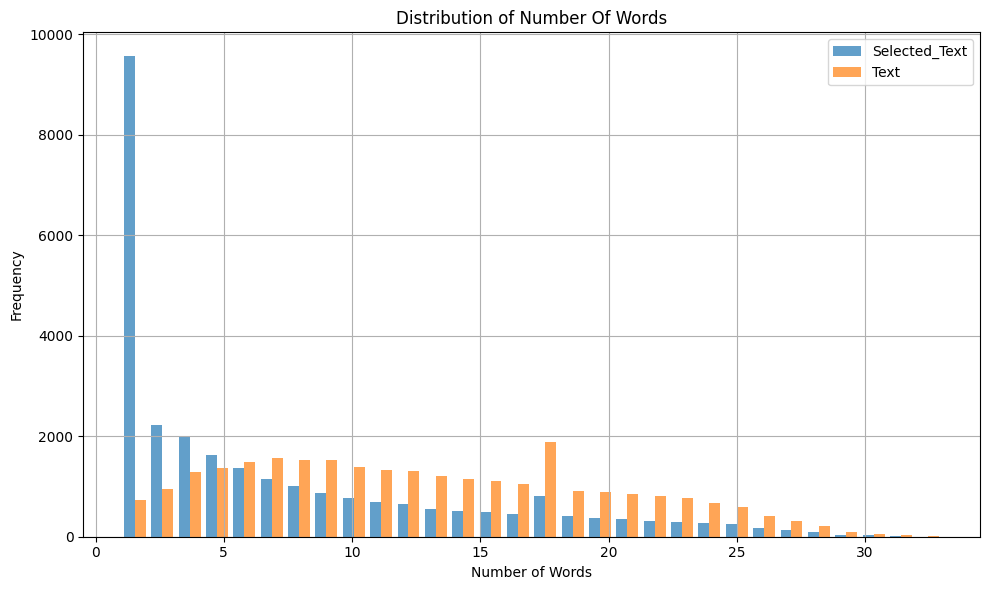

In [21]:
num_words_st = train['Num_words_ST'].dropna()
num_word_text = train['Num_word_text'].dropna()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist([num_words_st, num_word_text], bins=30, label=['Selected_Text', 'Text'], alpha=0.7)
plt.title('Distribution of Number Of Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

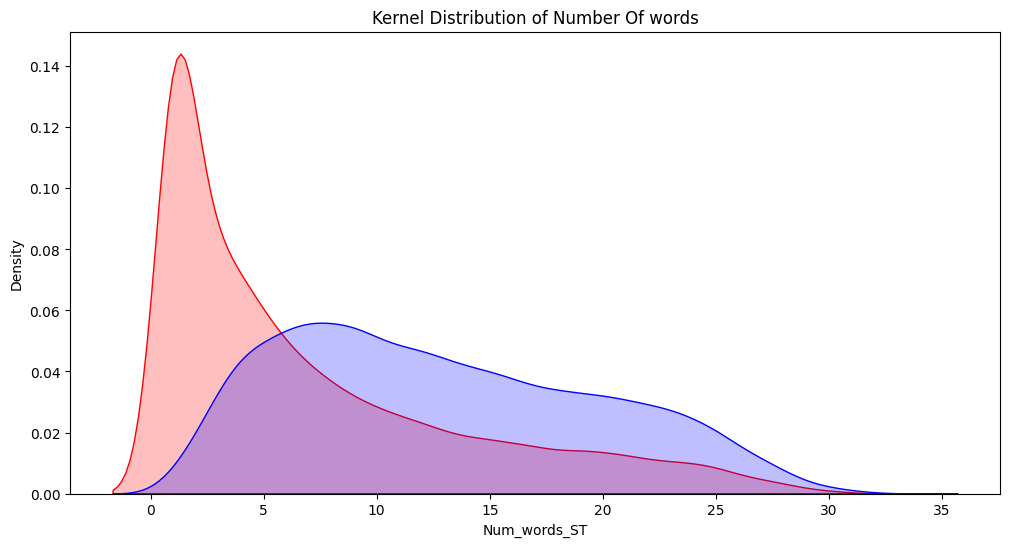

In [22]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

<Axes: xlabel='jaccard_score'>

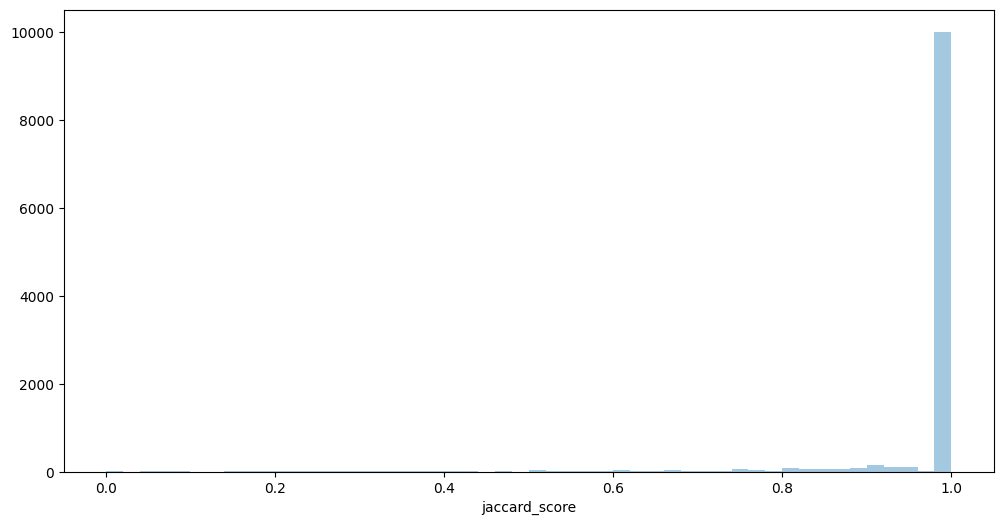

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)

In [20]:
k = train[train['Num_word_text']<=2]

We can see that there is similarity between text and selected text .Let's have closer look

In [21]:
k[k['sentiment']=='positive']

textID               text      selected_text sentiment  \
100    3ff9947935        **** right!        **** right!  positive   
151    d2f915b8c7      Good Morning!               Good  positive   
154    b4fa2d20e4           Good one           Good one  positive   
155    5714d8c2c3         Goodnight.          Goodnight  positive   
334    6d9bd35d32          Thank you              Thank  positive   
...           ...                ...                ...       ...   
26454  0ccac3f8b7  sweet situations.  sweet situations.  positive   
26484  6475ddf649            thanks              thanks  positive   
26499  274181e2e2             thanx               thanx  positive   
26933  28fc81d56a       wants cookie       wants cookie  positive   
27319  352e2cdec2        work   Yay!                Yay  positive   

       jaccard_score  Num_words_ST  Num_word_text  difference_in_words  
100              1.0             2              2                    0  
151              0.5             1              2                    1  
154              1.0             2              2                    0  
155              0.0             1              1                    0  
334              0.5             1              2                    1  
...              ...           ...            ...                  ...  
26454            1.0             2              2                    0  
26484            1.0             1              1                    0  
26499            1.0             1              1                    0  
26933            1.0             2              2                    0  
27319            0.0             1              2                    1  

[207 rows x 8 columns]

In [15]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [16]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [24]:
train.head()

textID                                               text  \
0  0fab80d6b2                        \treally oh sorry yall  lol   
1  8106d4c6fa                            beckett thanks so much    
2  3792c7b13e         youll be missed  bring me back  a keychain   
3  b58a92fe10                                    get lit  i am     
4  18180bb2ec       good morning to you   its so pretty outsi...   

     selected_text sentiment  jaccard_score  Num_words_ST  Num_word_text  \
0            sorry  negative       0.200000             1              5   
1   beckett thanks  positive       0.166667             2              5   
2    youll be miss  negative       0.222222             3              8   
3  get lit  i am     neutral       0.666667             5              5   
4        its so pr  positive       0.181818             3             10   

   difference_in_words  
0                    4  
1                    3  
2                    5  
3                    0  
4                    7

## Most Common words in our Target-Selected Text

In [19]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [28]:
train.head()

textID                                               text  \
0  0fab80d6b2                        \treally oh sorry yall  lol   
1  8106d4c6fa                            beckett thanks so much    
2  3792c7b13e         youll be missed  bring me back  a keychain   
3  b58a92fe10                                    get lit  i am     
4  18180bb2ec       good morning to you   its so pretty outsi...   

     selected_text sentiment  jaccard_score  Num_words_ST  Num_word_text  \
0            sorry  negative       0.200000             1              5   
1   beckett thanks  positive       0.166667             2              5   
2    youll be miss  negative       0.222222             3              8   
3  get lit  i am     neutral       0.666667             5              5   
4        its so pr  positive       0.181818             3             10   

   difference_in_words          temp_list  
0                    4            [sorry]  
1                    3  [beckett, thanks]  
2                    5      [youll, miss]  
3                    0         [get, lit]  
4                    7               [pr]

In [29]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

In [30]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [32]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [33]:
train.head()

textID                                               text  \
0  0fab80d6b2                        \treally oh sorry yall  lol   
1  8106d4c6fa                            beckett thanks so much    
2  3792c7b13e         youll be missed  bring me back  a keychain   
3  b58a92fe10                                    get lit  i am     
4  18180bb2ec       good morning to you   its so pretty outsi...   

     selected_text sentiment  jaccard_score  Num_words_ST  Num_word_text  \
0            sorry  negative       0.200000             1              5   
1   beckett thanks  positive       0.166667             2              5   
2    youll be miss  negative       0.222222             3              8   
3  get lit  i am     neutral       0.666667             5              5   
4        its so pr  positive       0.181818             3             10   

   difference_in_words          temp_list  \
0                    4            [sorry]   
1                    3  [beckett, thanks]   
2                    5      [youll, miss]   
3                    0         [get, lit]   
4                    7               [pr]   

                                temp_list1  
0           [really, oh, sorry, yall, lol]  
1                  [beckett, thanks, much]  
2   [youll, missed, bring, back, keychain]  
3                               [get, lit]  
4  [good, morning, pretty, outside, today]

In [34]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [35]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

In [36]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

In [37]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Blues')

In [38]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [41]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result;
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output:
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))

    specificnonly = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])

    return Unique_words

In [42]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


In [43]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


In [44]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


In [45]:
train.head()

textID                                               text  \
0  0fab80d6b2                        \treally oh sorry yall  lol   
1  8106d4c6fa                            beckett thanks so much    
2  3792c7b13e         youll be missed  bring me back  a keychain   
3  b58a92fe10                                    get lit  i am     
4  18180bb2ec       good morning to you   its so pretty outsi...   

     selected_text sentiment  jaccard_score  Num_words_ST  Num_word_text  \
0            sorry  negative       0.200000             1              5   
1   beckett thanks  positive       0.166667             2              5   
2    youll be miss  negative       0.222222             3              8   
3  get lit  i am     neutral       0.666667             5              5   
4        its so pr  positive       0.181818             3             10   

   difference_in_words          temp_list  \
0                    4            [sorry]   
1                    3  [beckett, thanks]   
2                    5      [youll, miss]   
3                    0         [get, lit]   
4                    7               [pr]   

                                temp_list1  
0           [really, oh, sorry, yall, lol]  
1                  [beckett, thanks, much]  
2   [youll, missed, bring, back, keychain]  
3                               [get, lit]  
4  [good, morning, pretty, outside, today]

In [46]:
test.head()

textID                                               text sentiment
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative
3  01082688c6                                        happy bday!  positive
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive

Modeling

In [21]:
!pip install -q transformers

In [22]:
!pip install tensorflow

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizerFast, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification



**CNN&RNN&LSTM**

In [50]:
def evaluate_model(model, X_val, y_val, label_encoder):
    """
    Evaluate a classification model and print metrics and confusion matrix.

    Args:
        model: Trained Keras model
        X_val: Validation features
        y_val: True labels (encoded)
        label_encoder: Fitted LabelEncoder used for the target

    Returns:
        None
    """
    # Get predictions
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Decode class labels
    target_names = label_encoder.classes_

    # Classification report
    print("Classification Report:")
    print(classification_report(y_val, y_pred, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


In [51]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-05-13 13:59:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-13 13:59:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-13 13:59:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [52]:
embedding_dim = 300
embedding_index = {}

with open("glove.6B.300d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Found {len(embedding_index)} word vectors.")


Found 400000 word vectors.


In [54]:
vocab_size = 20000  # Increased vocab
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train['text'].tolist())
sequences = tokenizer.texts_to_sequences(train['text'].tolist())
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train['sentiment'])
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels_encoded, test_size=0.2, random_state=42)


CNN_Model (Based on Paper)

In [55]:
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, Dense,
    Dropout, SpatialDropout1D, BatchNormalization
)

cnn_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=100,
        weights=[embedding_matrix],
        trainable=False  # freeze GloVe embeddings
    ),
    SpatialDropout1D(0.2),
    Conv1D(256, 3, activation='relu'),
    BatchNormalization(),
    Conv1D(128, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  # 3 classes
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [56]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)

Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 114s 322ms/step - accuracy: 0.3828 - loss: 1.6877 - val_accuracy: 0.5930 - val_loss: 1.0075
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 101s 293ms/step - accuracy: 0.5792 - loss: 0.9278 - val_accuracy: 0.6326 - val_loss: 0.8271
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 148s 309ms/step - accuracy: 0.6477 - loss: 0.8229 - val_accuracy: 0.6847 - val_loss: 0.7699
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 140s 305ms/step - accuracy: 0.6694 - loss: 0.7837 - val_accuracy: 0.6745 - val_loss: 0.7751
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 140s 300ms/step - accuracy: 0.6951 - loss: 0.7386 - val_accuracy: 0.6823 - val_loss: 0.7615
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 143s 302ms/step - accuracy: 0.7075 - loss: 0.7107 - val_accuracy: 0.6770 - val_loss: 0.7733
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 102s 297ms/step - accuracy: 0.7109 - loss: 0.6882 - val_accuracy: 0.6823 - val_loss: 0.7404
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 101s 293ms/step - accuracy: 0.7256 -

172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.59      0.67      1565
     neutral       0.61      0.81      0.70      2244
    positive       0.81      0.66      0.73      1687

    accuracy                           0.70      5496
   macro avg       0.74      0.68      0.70      5496
weighted avg       0.72      0.70      0.70      5496



<Figure size 800x600 with 0 Axes>

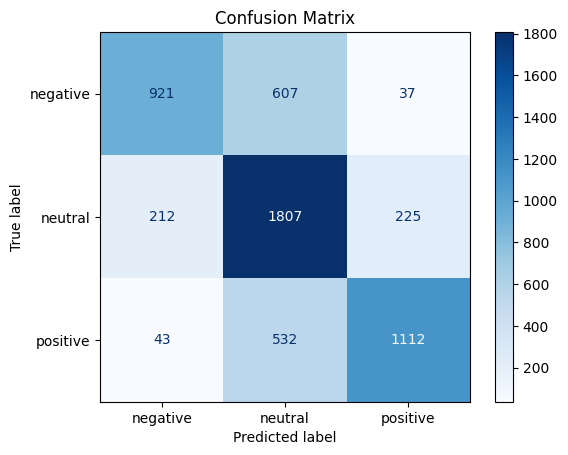

In [57]:
evaluate_model(cnn_model, X_val, y_val, label_encoder)

RNN (Hand-Made)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, SimpleRNN, Dense, Dropout,
    SpatialDropout1D, Bidirectional
)

rnn_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=100,
        weights=[embedding_matrix],
        trainable=False
    ),
    SpatialDropout1D(0.3),
    Bidirectional(SimpleRNN(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

rnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [59]:
rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)

Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step - accuracy: 0.4028 - loss: 1.1186 - val_accuracy: 0.5344 - val_loss: 0.9633
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 73s 102ms/step - accuracy: 0.5105 - loss: 0.9801 - val_accuracy: 0.5793 - val_loss: 0.9225
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - accuracy: 0.5637 - loss: 0.9229 - val_accuracy: 0.6243 - val_loss: 0.8685
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.5880 - loss: 0.8960 - val_accuracy: 0.4367 - val_loss: 1.2193
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.5569 - loss: 0.9469 - val_accuracy: 0.5315 - val_loss: 0.9687


172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.57      0.61      1565
     neutral       0.57      0.71      0.63      2244
    positive       0.73      0.56      0.63      1687

    accuracy                           0.62      5496
   macro avg       0.65      0.61      0.62      5496
weighted avg       0.64      0.62      0.62      5496



<Figure size 800x600 with 0 Axes>

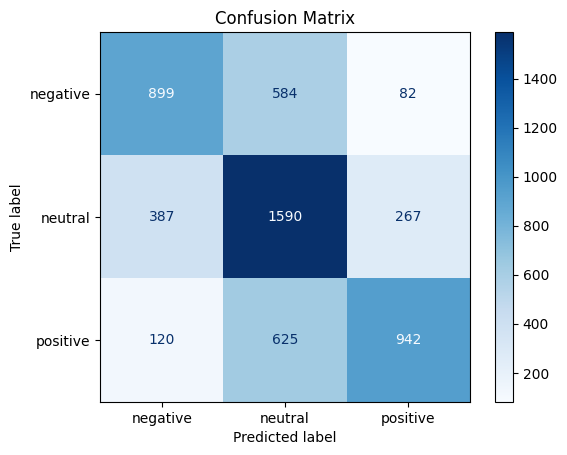

In [60]:
evaluate_model(rnn_model, X_val, y_val, label_encoder)

LSTM (Hand-Made)

In [61]:
lstm_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=100,
        weights=[embedding_matrix],
        trainable=False
    ),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [62]:
lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)

Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 151s 416ms/step - accuracy: 0.4015 - loss: 1.0902 - val_accuracy: 0.4083 - val_loss: 1.0874
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 209s 437ms/step - accuracy: 0.4036 - loss: 1.0879 - val_accuracy: 0.4083 - val_loss: 1.0861
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 195s 417ms/step - accuracy: 0.4017 - loss: 1.0884 - val_accuracy: 0.4083 - val_loss: 1.0861
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 141s 411ms/step - accuracy: 0.4015 - loss: 1.0882 - val_accuracy: 0.4083 - val_loss: 1.0867


172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      1565
     neutral       0.41      1.00      0.58      2244
    positive       0.00      0.00      0.00      1687

    accuracy                           0.41      5496
   macro avg       0.14      0.33      0.19      5496
weighted avg       0.17      0.41      0.24      5496



<Figure size 800x600 with 0 Axes>

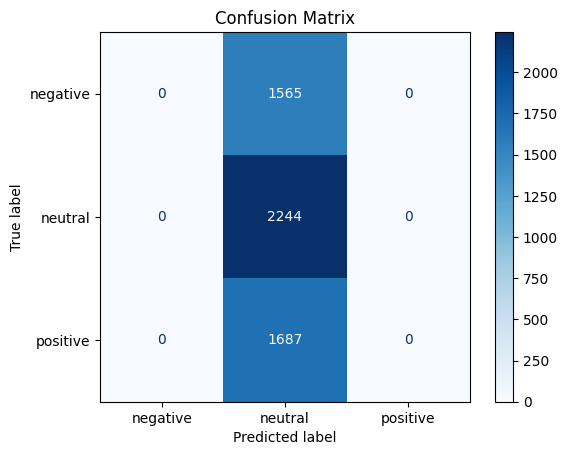

In [63]:
evaluate_model(lstm_model, X_val, y_val, label_encoder)


📊 Evaluating CNN model...
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step

🔍 Classification Report for CNN:
              precision    recall  f1-score   support

    negative       0.78      0.59      0.67      1565
     neutral       0.61      0.81      0.70      2244
    positive       0.81      0.66      0.73      1687

    accuracy                           0.70      5496
   macro avg       0.74      0.68      0.70      5496
weighted avg       0.72      0.70      0.70      5496

✅ Accuracy: 0.6987


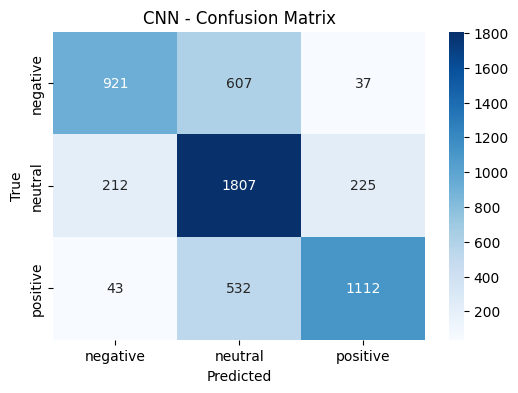


📊 Evaluating RNN model...
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step

🔍 Classification Report for RNN:
              precision    recall  f1-score   support

    negative       0.64      0.57      0.61      1565
     neutral       0.57      0.71      0.63      2244
    positive       0.73      0.56      0.63      1687

    accuracy                           0.62      5496
   macro avg       0.65      0.61      0.62      5496
weighted avg       0.64      0.62      0.62      5496

✅ Accuracy: 0.6243


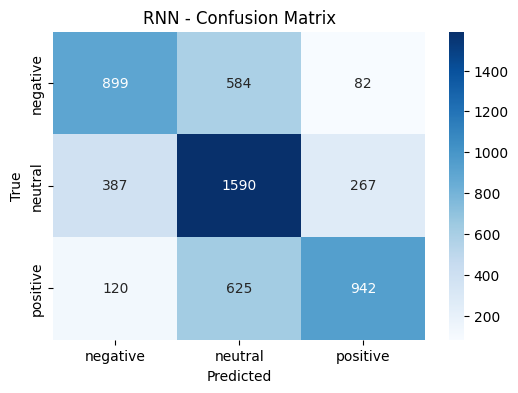


📊 Evaluating LSTM model...
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step

🔍 Classification Report for LSTM:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      1565
     neutral       0.41      1.00      0.58      2244
    positive       0.00      0.00      0.00      1687

    accuracy                           0.41      5496
   macro avg       0.14      0.33      0.19      5496
weighted avg       0.17      0.41      0.24      5496

✅ Accuracy: 0.4083


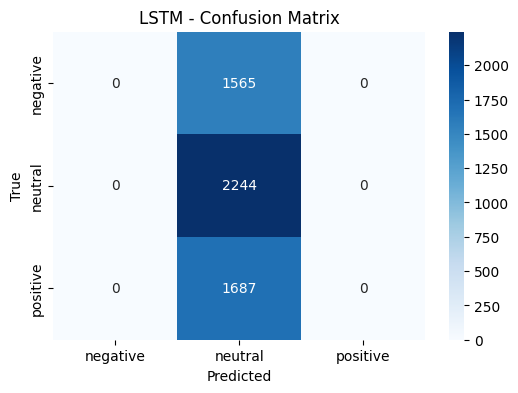


📋 Summary:
CNN Accuracy: 0.6987
RNN Accuracy: 0.6243
LSTM Accuracy: 0.4083


In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List of models and names
models = [
    ("CNN", cnn_model),
    ("RNN", rnn_model),
    ("LSTM", lstm_model)
]

# Store results
results = {}

for name, model in models:
    print(f"\n📊 Evaluating {name} model...")

    # Predict class probabilities
    y_pred_probs = model.predict(X_val)

    # Take argmax to get class predictions
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification report
    print(f"\n🔍 Classification Report for {name}:")
    print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

    # Accuracy
    acc = np.mean(y_val == y_pred)
    print(f"✅ Accuracy: {acc:.4f}")

    # Save results
    results[name] = {
        'accuracy': acc,
        'preds': y_pred
    }

    # Optional: Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 📈 Summary comparison
print("\n📋 Summary:")
for name, result in results.items():
    print(f"{name} Accuracy: {result['accuracy']:.4f}")

In [65]:
def preprocess_texts(texts, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded

def predict_sentiment(model, texts, tokenizer, max_len, label_encoder):
    # Preprocess input
    processed = preprocess_texts(texts, tokenizer, max_len)

    # Predict
    preds = model.predict(processed)
    pred_labels = np.argmax(preds, axis=1)

    # Decode labels
    decoded_preds = label_encoder.inverse_transform(pred_labels)
    return decoded_preds

# 🧪 Sample test data
sample_texts = [
    "I absolutely loved this product!",
    "It was okay, not great but not terrible.",
    "I hated the experience, very disappointing.",
    "Service was fast but the food was average.",
    "This is the worst I've ever seen."
]

# 🔄 Test with all models
for name, model in [("CNN", cnn_model), ("RNN", rnn_model), ("LSTM", lstm_model)]:
    print(f"\n🔍 Predictions using {name} model:")
    predictions = predict_sentiment(model, sample_texts, tokenizer, 100, label_encoder)
    for text, pred in zip(sample_texts, predictions):
        print(f"Text: \"{text}\" → Sentiment: **{pred}**")



🔍 Predictions using CNN model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Text: "I absolutely loved this product!" → Sentiment: **positive**
Text: "It was okay, not great but not terrible." → Sentiment: **neutral**
Text: "I hated the experience, very disappointing." → Sentiment: **negative**
Text: "Service was fast but the food was average." → Sentiment: **neutral**
Text: "This is the worst I've ever seen." → Sentiment: **negative**

🔍 Predictions using RNN model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Text: "I absolutely loved this product!" → Sentiment: **positive**
Text: "It was okay, not great but not terrible." → Sentiment: **negative**
Text: "I hated the experience, very disappointing." → Sentiment: **negative**
Text: "Service was fast but the food was average." → Sentiment: **neutral**
Text: "This is the worst I've ever seen." → Sentiment: **negative**

🔍 Predictions using LSTM model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Text: "I absolutely loved this product!" → Sentiment: **neutra

Bert & roBerta

Bert

In [67]:
from transformers import BertTokenizerFast, TFBertForSequenceClassification
from transformers import create_optimizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# 1. Label encode
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train['sentiment'])

# 2. Train/test split on raw text and labels
train_texts, val_texts, y_train, y_val = train_test_split(
    train['text'].tolist(),
    labels,
    test_size=0.2,
    random_state=42
)

# 3. Tokenize training and validation texts
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)

# 4. Convert to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(16)



# Define optimizer and learning rate scheduler
batch_size = 16
num_train_steps = len(train_dataset) * 1  # num_epochs = 3
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0,
)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# 7. Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=1)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1374/1374 [==============================] - 16096s 12s/step - loss: 0.5865 - accuracy: 0.7566 - val_loss: 0.5407 - val_accuracy: 0.7789


Roberta

In [24]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, create_optimizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# 1. Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train['sentiment'])

# 2. Train/test split
train_texts, val_texts, y_train, y_val = train_test_split(
    train['text'].tolist(),
    labels,
    test_size=0.2,
    random_state=42
)

# 3. Tokenization
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)

# 4. Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(16)

# 5. Optimizer and scheduler
batch_size = 16
num_epochs = 1
num_train_steps = len(train_dataset) * num_epochs
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0,
)

# 6. Compile model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592899    
 ificationHead)                                                  
                                                                 
Total params: 124647939 (475.49 MB)
Trainable params: 124647939 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# 7. Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs
)


1374/1374 [==============================] - 28445s 21s/step - loss: 0.5909 - accuracy: 0.7541 - val_loss: 0.5418 - val_accuracy: 0.7817
